In [102]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [182]:
# read in our data
url = "https://raw.githubusercontent.com/SamIlic/Stat479_Project/master/Data/prices.csv"
df_ORIGINAL = pd.read_csv(url)


### Clean Data

In [194]:
df_features = df_ORIGINAL
df_features['date'] = pd.to_datetime(df_features['date'])
df_features.head()

,date,Ticker,open,close,low,high,volume
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000


In [195]:
### Create Lag Features
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['date', 'Ticker', 'close']].copy()
        # generate dataframe to shift index by i day. 415 is number of stocks
        df_lag['date'] = df_lag['date'].shift(-i*415)
        df_lag.columns = ['date', 'Ticker', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['date', 'Ticker'], right_on = ['date', 'Ticker'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [196]:
df_features = create_lag_features(df_features, 5) # 5 lag features

# Sanity Check
df_temp = df_features.loc[df_features['Ticker'] == "AAPL"]
df_temp.head(7)

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3,lag4,lag5
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400,NaN,NaN,NaN,NaN,NaN,NaN
417,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200,0.172887,NaN,NaN,NaN,NaN,NaN
832,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000,-1.590633,0.172887,NaN,NaN,NaN,NaN
1247,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800,-0.184858,-1.590633,0.172887,NaN,NaN,NaN
1662,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700,0.664833,-0.184858,-1.590633,0.172887,NaN,NaN
2077,2010-01-11,AAPL,30.400000,30.015715,29.778572,30.428572,115557400,-0.882160,0.664833,-0.184858,-1.590633,0.172887,NaN
2492,2010-01-12,AAPL,29.884285,29.674286,29.488571,29.967142,148614900,-1.137500,-0.882160,0.664833,-0.184858,-1.590633,0.172887


In [197]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)

# finds all unique stocks
uniq_stocks = set(df_features['Ticker'])

In [198]:
# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
# Final model we should use say 100
# when training, for the purpose of time, we should use <=10
Ticker = "AAPL"
X_one = df_features.loc[df_features['Ticker'] == Ticker, :]

In [199]:
a = ['Date', 'Ticker', 'Open', 'Close', 'Low', 'High', 'Volume', 'Today']
for i in range(1,6):
    a.append('lag' + str(i))
X_one.columns = a
X_one = X_one.reset_index(drop = True)

In [200]:
# Technical Indicators
from technical_indicators import * # import all function

X_one = standard_deviation(X_one, 14)

X_one = relative_strength_index(X_one, 14) # periods
X_one = average_directional_movement_index(X_one, 14, 13) # n, n_ADX
X_one = moving_average(X_one, 21) # periods
X_one = exponential_moving_average(X_one, 21) # periods
X_one = momentum(X_one, 14) # 

X_one = average_true_range(X_one, 14)
X_one = bollinger_bands(X_one, 21)
X_one = ppsr(X_one)
X_one = stochastic_oscillator_k(X_one)
X_one = stochastic_oscillator_d(X_one, 14)
X_one = trix(X_one, 14)
X_one = macd(X_one, 26, 12)
X_one = mass_index(X_one)
X_one = vortex_indicator(X_one, 14)

X_one = kst_oscillator(X_one, 10, 10, 10, 15, 10, 15, 20, 30)
X_one = true_strength_index(X_one, 25, 13)

#X_one = accumulation_distribution(X_one, 14) # Causes Problems, apparently
X_one = chaikin_oscillator(X_one)
X_one = money_flow_index(X_one, 14)
X_one = on_balance_volume(X_one, 14)
X_one = force_index(X_one, 14)
X_one = ease_of_movement(X_one, 14)
X_one = commodity_channel_index(X_one, 14)
X_one = keltner_channel(X_one, 14)
X_one = ultimate_oscillator(X_one)
X_one = donchian_channel(X_one, 14)

# # df.plot(y=['Close'])
# # df.plot(y=['RSI_14'])
# X_one.tail(5)

In [201]:
# drop earlier data with missing lag features
X_one.dropna(inplace=True)
X_one = X_one.reset_index(drop = True)

In [202]:
# Sanity Check
X_one.head(10)

,Date,Ticker,Open,Close,Low,High,Volume,Today,lag1,lag2,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
0,2010-03-16,AAPL,32.025715,32.064285,31.787144,32.139999,111727000,0.272517,-1.218010,0.487804,...,0.857143,98493650.0,-1.160476e+07,7.072544e-10,0.917130,30.844762,31.341497,30.348027,4.838738,1.922857
1,2010-03-17,AAPL,32.128571,32.017143,31.895714,32.349998,112739200,-0.147023,0.272517,-1.218010,...,0.857143,78563600.0,-1.691937e+08,7.408014e-10,0.887389,31.089966,31.558231,30.621701,4.649647,1.595715
2,2010-03-18,AAPL,32.014286,32.092857,31.801428,32.142857,85527400,0.236480,-0.147023,0.272517,...,0.785714,75610900.0,-1.182852e+08,5.626915e-10,0.720634,31.295646,31.755952,30.835340,4.628263,2.205715
3,2010-03-19,AAPL,32.112858,31.750000,31.604286,32.177143,139861400,-1.068329,0.236480,-0.147023,...,0.714286,55797700.0,4.428839e+06,3.718736e-10,0.444165,31.447959,31.907857,30.988061,4.214674,2.395716
4,2010-03-22,AAPL,31.495714,32.107143,31.450001,32.285713,114104900,1.124861,-1.068329,0.236480,...,0.714286,74064950.0,-6.253631e+07,3.023533e-10,0.454084,31.595850,32.083911,31.107789,4.341849,2.395716
5,2010-03-23,AAPL,32.234287,32.622856,32.014286,32.682858,150607800,1.606224,1.124861,-1.068329,...,0.785714,78178850.0,1.565750e+08,4.662736e-10,1.060184,31.779864,32.295986,31.263741,4.636000,2.202856
6,2010-03-24,AAPL,32.520000,32.767143,32.501427,32.885715,149445100,0.442289,1.606224,1.124861,...,0.785714,82317050.0,1.544376e+08,4.979047e-10,1.781372,31.973129,32.493333,31.452925,4.704537,3.427143
7,2010-03-25,AAPL,32.988571,32.378571,32.321430,32.995716,135571100,-1.185861,0.442289,1.606224,...,0.714286,56568750.0,-9.826726e+07,2.426265e-10,1.339786,32.077177,32.593810,31.560544,4.047512,3.482859
8,2010-03-26,AAPL,32.707142,32.985714,32.650002,33.135715,160218800,1.875140,-1.185861,0.442289,...,0.714286,60336350.0,8.906609e+07,2.433193e-10,2.045975,32.192755,32.725306,31.660204,4.397064,4.184286
9,2010-03-29,AAPL,33.285713,33.198570,33.088570,33.410000,135186100,0.645298,1.875140,-1.185861,...,0.714286,53559300.0,-1.270018e+08,2.013643e-10,2.193189,32.301497,32.784456,31.818537,4.237465,4.252859


### DT Model

#### Train-Test Split

READ THIS - https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

1) __Train-Test__ split that respect temporal order of observations.  
2) __Multiple Train-Test__ splits that respect temporal order of observations.  
3) __Walk-Forward Validation__ where a model may be updated each time step new data is received.  

In [206]:
### Meenmo
y_one = X_one['Today']
# Can't use tomorrows data to predict tomorrows prices!!!
X_one.drop(['Open','Close','Low','High','Today'], axis = 1, inplace = True)

X_train_one = X_one.loc[(X_one['Date'] < '2016-01-01'),:]
y_train_one = y_one[X_train_one.index]

X_test_one = X_one.loc[(X_one['Date'] < '2016-01-01'),:]
y_test_one = y_one[X_test_one.index]

#X_train_one.drop(['Date'], axis = 1, inplace = True)
#X_test_one.drop(['Date'], axis = 1, inplace = True)

X_train_one.head(7)

# ### Jonathan
# # training data is anything less than 2016
# X_train = df_features.loc[(df_features['date'] < '2016-01-01'),:]
# y_train = X_train['Today']

# # testing data is 2016
# X_test = df_features.loc[(df_features['date'] > '2015-12-31'), :]
# y_test = X_test['Today']

# ### Drop columns
# ## Train
# # sam might need these column for feature engineering
# X_train.drop(['open','close','low','high','Today'], axis = 1, inplace = True)
# ## Test
# # sam might need these column for feature engineering
# X_test.drop(['open','close','low','high','Today'], axis = 1, inplace = True)

# X_train.head(7)

,Date,Ticker,Volume,lag1,lag2,lag3,lag4,lag5,STD_14,RSI_14,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
0,2010-03-16,AAPL,111727000,-1.218010,0.487804,0.293549,0.816065,1.798434,1.237845,0.647188,...,0.857143,98493650.0,-1.160476e+07,7.072544e-10,0.917130,30.844762,31.341497,30.348027,4.838738,1.922857
1,2010-03-17,AAPL,112739200,0.272517,-1.218010,0.487804,0.293549,0.816065,1.113362,0.680559,...,0.857143,78563600.0,-1.691937e+08,7.408014e-10,0.887389,31.089966,31.558231,30.621701,4.649647,1.595715
2,2010-03-18,AAPL,85527400,-0.147023,0.272517,-1.218010,0.487804,0.293549,0.989406,0.648769,...,0.785714,75610900.0,-1.182852e+08,5.626915e-10,0.720634,31.295646,31.755952,30.835340,4.628263,2.205715
3,2010-03-19,AAPL,139861400,0.236480,-0.147023,0.272517,-1.218010,0.487804,0.893243,0.583060,...,0.714286,55797700.0,4.428839e+06,3.718736e-10,0.444165,31.447959,31.907857,30.988061,4.214674,2.395716
4,2010-03-22,AAPL,114104900,-1.068329,0.236480,-0.147023,0.272517,-1.218010,0.766624,0.534203,...,0.714286,74064950.0,-6.253631e+07,3.023533e-10,0.454084,31.595850,32.083911,31.107789,4.341849,2.395716
5,2010-03-23,AAPL,150607800,1.124861,-1.068329,0.236480,-0.147023,0.272517,0.619532,0.627028,...,0.785714,78178850.0,1.565750e+08,4.662736e-10,1.060184,31.779864,32.295986,31.263741,4.636000,2.202856
6,2010-03-24,AAPL,149445100,1.606224,1.124861,-1.068329,0.236480,-0.147023,0.418378,0.666230,...,0.785714,82317050.0,1.544376e+08,4.979047e-10,1.781372,31.973129,32.493333,31.452925,4.704537,3.427143


In [208]:
# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
# Final model we should use say 100
# when training, for the purpose of time, we should use <=10
Ticker = "AAPL"
X_train_one = X_train.loc[X_train['Ticker'] == Ticker, :]
y_train_one_list = list(y_train[X_train_one.index])
X_train_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

X_test_one = X_test.loc[X_test['Ticker'] == Ticker, :]
y_test_one_list = list(y_test[X_test_one.index])
X_test_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

In [209]:
# # random forest regression
# rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 10)
# rf.fit(X_train_one.values.astype(np.float), y_train_one.values.astype(np.float))
# print("MSE: ", mean_squared_error(y_test_one.values.astype(np.float), rf.predict(X_test_one.values.astype(np.float))))

# random forest regression
rf = RandomForestRegressor(random_state = 0, n_jobs = 1, n_estimators = 10)
rf.fit(X_train_one, y_train_one_list)
print(mean_squared_error(y_test_one_list, rf.predict(X_test_one)))



2.3497373822805887


In [213]:
# from sklearn.metrics import r2_score
# print("R2: ", r2_score(y_test_one.values.astype(np.float), rf.predict(X_test_one.values.astype(np.float))))

from sklearn.metrics import r2_score
#r2_score(y_test_one.values.astype(np.float), rf.predict(X_test_one.values.astype(np.float)))
r2_score(y_test_one_list, rf.predict(X_test_one))

-0.08851116429567574

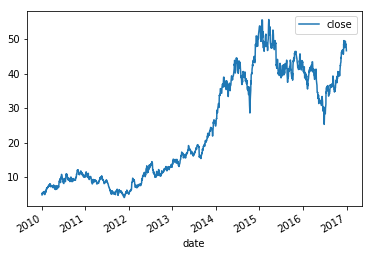

In [44]:
import matplotlib.pyplot as plt

a = df_features.loc[df_features.loc[:,'Ticker'] == 'AAL', ['date', 'close']]
a.plot(x = 'date', y = 'close')
plt.show()